In [0]:
products = "dbfs:/mnt/s3dataread/products.csv"
sales = "dbfs:/mnt/s3dataread/5m Sales Records.csv"

## Sales and inventory optimization analysis for Flipkart ##

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [0]:
# spark = SparkSession.builder.appName("603_project").getOrCreate()

## Data Ingesting and Cleaning of Product

In [0]:
df_product = spark.read.csv(products, header=True, inferSchema=True)
# df_product.show()

In [0]:
print((df_product.count(), len(df_product.columns)))

(32226, 13)


In [0]:
value_map = {
    "Baby Care": 'Baby Food',
    "Atta, Rice & Dal": 'Cereal',
    "Chicken, Meat & Fish": 'Meat',
    'Dry Fruits, Masala & Oil':"Household",
    'Sauces & Spreads': "Household",
    'Aura Decor Private Limited': "Household",
    "Organic & Premium":'Vegetables & Fruits',
    'Tea, Coffee & Health Drinks' : "Beverages",
    'Cold Drinks & Juices':"Beverages",
    'Home & Office' : "Office Supplies",
    'Cleaning Essentials' : "Personal Care",
    'Pharma & Wellness' : "Personal Care",
    'Sweet Tooth':"Snacks",
    'Munchies':"Snacks",
    'Paan Corner':"Snacks",
    'Instant & Frozen Food':"Snacks",
    'Dairy & Breakfast':'Dairy & Bakery Items',
    'Bakery & Biscuits':'Dairy & Bakery Items'
}

## Create User Defined Function to perform the replacement
replacement_udf = F.udf(lambda value: value_map.get(value, value)) 

# Replace the values
df_product = df_product.withColumn("Category", replacement_udf("l0_category"))
df_product.show()

+---+----------+--------------------+-----------------+------------+--------------------+--------------------+-----------+------------+------------+--------------+--------------+--------------+--------+
|_c0|product_id|        product_name|             unit|product_type|          brand_name|   manufacturer_name|l0_category| l1_category| l2_category|l0_category_id|l1_category_id|l2_category_id|Category|
+---+----------+--------------------+-----------------+------------+--------------------+--------------------+-----------+------------+------------+--------------+--------------+--------------+--------+
|  0|    476763|    Christmas - Card|           1 unit|        Card|                null|                 HOT|   Specials|Bill Breaker|Bill Breaker|           343|          1741|          1741|Specials|
|  1|    483436|Plum BodyLovin' H...|            20 ml|      Sample|     Plum BodyLovin'|Pureplay Skin Sci...|   Specials|  Free Store|  Free Store|           343|          1493|          

In [0]:
category_groups = df_product.groupBy('Category').count()
category_groups.show()

+--------------------+-----+
|            Category|count|
+--------------------+-----+
|           Baby Food|  994|
|Dairy & Bakery Items| 2655|
|              Cereal| 1904|
| Vegetables & Fruits| 2303|
|                Meat|  192|
|            Specials|  154|
|           Household| 4560|
|           Beverages| 3013|
|     Office Supplies| 4733|
|       Personal Care| 5352|
|            Pet Care|  727|
|              Snacks| 5639|
+--------------------+-----+



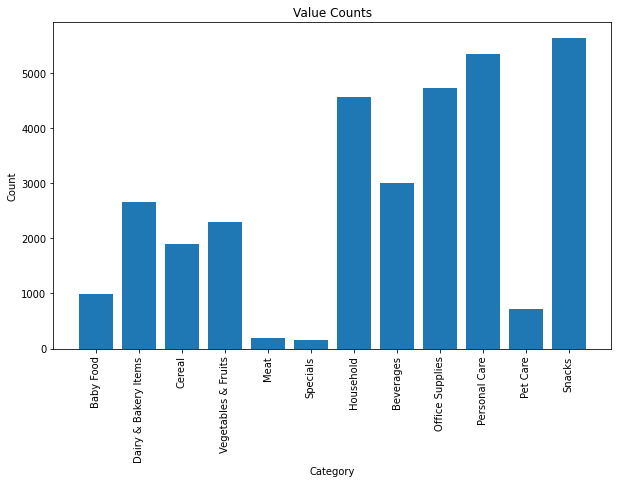

In [0]:
value_counts_pd = category_groups.toPandas()

# Plot the value counts using a bar graph
plt.figure(figsize=(10, 6))
plt.bar(value_counts_pd["Category"], value_counts_pd["count"])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Value Counts")
plt.xticks(rotation=90)
plt.show()

In [0]:
# aws_bucket_name = "data603output"
# mount_name = "s3datawrite"

# dbutils.fs.mount(f"s3a://{access_key}:{encoded_secret_key}@{aws_bucket_name}", f"/mnt/{mount_name}")


In [0]:
# dbutils.fs.unmount(f"/mnt/s3datawrite")
# OR #


In [0]:
# display(dbutils.fs.ls(f"/mnt/{mount_name}"))

In [0]:
# category_groups.write.format("csv").mode("overwrite").save("dbfs:/mnt/s3datawrite/prod_category_groups.csv")
# dbfs:/mnt/s3dataread/products.csv


In [0]:
df_product.columns

Out[18]: ['_c0',
 'product_id',
 'product_name',
 'unit',
 'product_type',
 'brand_name',
 'manufacturer_name',
 'l0_category',
 'l1_category',
 'l2_category',
 'l0_category_id',
 'l1_category_id',
 'l2_category_id',
 'Category']

In [0]:
df_product=df_product.drop('_c0','product_id','brand_name','manufacturer_name','l0_category','l1_category','l2_category','l0_category_id','l1_category_id','l2_category_id',)

In [0]:
from pyspark.sql.functions import col,isnan,when,count

df_Columns_prod=['product_name', 'unit', 'product_type', 'Category']
df_product.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_Columns_prod]
   ).show()

+------------+----+------------+--------+
|product_name|unit|product_type|Category|
+------------+----+------------+--------+
|           0|   0|           0|       0|
+------------+----+------------+--------+



In [0]:
df_product.count()

Out[21]: 32226

In [0]:
# df_product.write.format("csv").mode("overwrite").save("dbfs:/mnt/s3datawrite/df_product.csv")

In [0]:
df_product.columns

Out[23]: ['product_name', 'unit', 'product_type', 'Category']

## Data Ingesting and Cleaning of Sales

In [0]:
df_sales = spark.read.csv(sales, header=True, inferSchema=True)
df_sales.show()

+--------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|              Region|     Country|      Item Type|Sales Channel|Order Priority|Order Date| Order ID| Ship Date|Units Sold|Unit Price|Unit Cost|Total Revenue|Total Cost|Total Profit|
+--------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|Australia and Oce...|       Palau|Office Supplies|       Online|             H|2016-03-06|517073523|2016-03-26|      2401|    651.21|   524.96|   1563555.21|1260428.96|   303126.25|
|              Europe|      Poland|      Beverages|       Online|             L|2010-04-18|380507028|2010-05-26|      9340|     47.45|    31.79|     443183.0|  296918.6|    146264.4|
|       North America|      Canada|         Cereal|       Online|             M|2015-

In [0]:
print((df_sales.count(), len(df_sales.columns)))

(5000000, 14)


In [0]:
df_sales.columns

Out[26]: ['Region',
 'Country',
 'Item Type',
 'Sales Channel',
 'Order Priority',
 'Order Date',
 'Order ID',
 'Ship Date',
 'Units Sold',
 'Unit Price',
 'Unit Cost',
 'Total Revenue',
 'Total Cost',
 'Total Profit']

In [0]:
value_map = {
    "Clothes": 'Pet Care',
    "Vegetables": 'Vegetables & Fruits',
    "Fruits":'Dairy & Bakery Items',
    'Cosmetics':"Specials"
}

replacement_udf = F.udf(lambda value: value_map.get(value, value))
df_sales= df_sales.withColumn("Item Type", replacement_udf("Item Type"))

# Show the updated DataFrame
df_sales.show()

+--------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|              Region|     Country|      Item Type|Sales Channel|Order Priority|Order Date| Order ID| Ship Date|Units Sold|Unit Price|Unit Cost|Total Revenue|Total Cost|Total Profit|
+--------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+
|Australia and Oce...|       Palau|Office Supplies|       Online|             H|2016-03-06|517073523|2016-03-26|      2401|    651.21|   524.96|   1563555.21|1260428.96|   303126.25|
|              Europe|      Poland|      Beverages|       Online|             L|2010-04-18|380507028|2010-05-26|      9340|     47.45|    31.79|     443183.0|  296918.6|    146264.4|
|       North America|      Canada|         Cereal|       Online|             M|2015-

In [0]:
# df_sales.write.format("csv").mode("overwrite").save("dbfs:/mnt/s3datawrite/df_sales.csv")

In [0]:
df_columns_sales=['Region',
 'Country',
 'Item Type',
 'Sales Channel',
 'Order Priority',
#  'Order Date',
 'Order ID',
#  'Ship Date',
 'Units Sold',
 'Unit Price',
 'Unit Cost',
 'Total Revenue',
 'Total Cost',
 'Total Profit']
df_sales.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_columns_sales]).show()

+------+-------+---------+-------------+--------------+--------+----------+----------+---------+-------------+----------+------------+
|Region|Country|Item Type|Sales Channel|Order Priority|Order ID|Units Sold|Unit Price|Unit Cost|Total Revenue|Total Cost|Total Profit|
+------+-------+---------+-------------+--------------+--------+----------+----------+---------+-------------+----------+------------+
|     0|      0|        0|            0|             0|       0|         0|         0|        0|            0|         0|           0|
+------+-------+---------+-------------+--------------+--------+----------+----------+---------+-------------+----------+------------+



In [0]:
df_sales.dtypes

Out[30]: [('Region', 'string'),
 ('Country', 'string'),
 ('Item Type', 'string'),
 ('Sales Channel', 'string'),
 ('Order Priority', 'string'),
 ('Order Date', 'date'),
 ('Order ID', 'int'),
 ('Ship Date', 'date'),
 ('Units Sold', 'int'),
 ('Unit Price', 'double'),
 ('Unit Cost', 'double'),
 ('Total Revenue', 'double'),
 ('Total Cost', 'double'),
 ('Total Profit', 'double')]

In [0]:
df_sales.select("Order Date").show()

+----------+
|Order Date|
+----------+
|2016-03-06|
|2010-04-18|
|2015-01-08|
|2014-01-19|
|2019-04-26|
|2012-03-03|
|2012-11-24|
|2011-03-18|
|2014-05-10|
|2020-05-25|
|2012-11-12|
|2019-07-25|
|2010-12-25|
|2012-08-03|
|2013-12-03|
|2016-09-22|
|2018-11-22|
|2019-10-27|
|2015-01-25|
|2012-05-21|
+----------+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import dayofweek, year, month, dayofmonth, to_date, date_format

df_sales = df_sales.withColumn("Order Date", to_date(df_sales["Order Date"], "M/d/yyyy"))

df_sales = df_sales.withColumn("day", dayofmonth("Order Date"))
df_sales = df_sales.withColumn("weekday", date_format("Order Date", "EEEE"))
df_sales = df_sales.withColumn("month", date_format("Order Date", "MMMM"))
df_sales = df_sales.withColumn('year', year('Order Date'))

# show the updated dataframe
df_sales.show()

+--------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+---+--------+---------+----+
|              Region|     Country|      Item Type|Sales Channel|Order Priority|Order Date| Order ID| Ship Date|Units Sold|Unit Price|Unit Cost|Total Revenue|Total Cost|Total Profit|day| weekday|    month|year|
+--------------------+------------+---------------+-------------+--------------+----------+---------+----------+----------+----------+---------+-------------+----------+------------+---+--------+---------+----+
|Australia and Oce...|       Palau|Office Supplies|       Online|             H|2016-03-06|517073523|2016-03-26|      2401|    651.21|   524.96|   1563555.21|1260428.96|   303126.25|  6|  Sunday|    March|2016|
|              Europe|      Poland|      Beverages|       Online|             L|2010-04-18|380507028|2010-05-26|      9340|     47.45|    31.79|     443183.

In [0]:
month_groups = df_sales.groupBy('month').count()
month_group_counts = month_groups.orderBy('count', ascending=False)
month_group_counts.show()

+---------+------+
|    month| count|
+---------+------+
|      May|436665|
|     July|436649|
|   August|436448|
|  January|436397|
|    March|436235|
|     June|422271|
|    April|422228|
| February|398110|
| December|397203|
|  October|396899|
|September|396818|
| November|384077|
+---------+------+



## Seasonality of Data

+---------+------+
|    month| count|
+---------+------+
| November|384077|
|September|396818|
|  October|396899|
| December|397203|
| February|398110|
|    April|422228|
|     June|422271|
|    March|436235|
|  January|436397|
|   August|436448|
|     July|436649|
|      May|436665|
+---------+------+



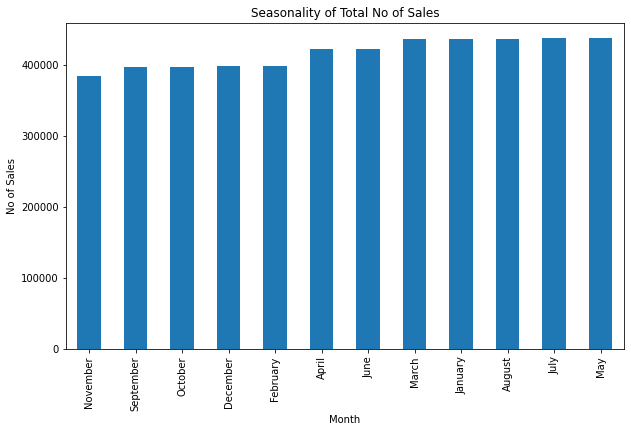

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Group the data by year and month, and calculate the average 'Total Profit' for each group
seasonality_df = df_sales.groupBy('month').count().orderBy('count')

# Show the seasonality DataFrame
seasonality_df.show()


pandas_df = seasonality_df.toPandas()
pandas_df.plot(x='month', y='count', figsize=(10, 6), kind='bar', legend=False)
plt.xlabel('Month')
plt.ylabel('No of Sales')
plt.title('Seasonality of Total No of Sales')
plt.show()


## Sales Performance Evaluation

Sales Performance Evaluation: Assessing the performance of sales teams or individual sales representatives based on key performance indicators (KPIs) such as revenue, customer acquisition, conversion rates, and customer satisfaction.

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, count, avg

# # Create a SparkSession
# spark = SparkSession.builder.getOrCreate()

# # Assuming you have a DataFrame called 'df' with the specified columns

# Calculate total revenue, total units sold, and total profit by region
region_performance = df_sales.groupBy('Region').agg(sum('Total Revenue').alias('Total Revenue'),
#                                               sum('Units Sold').alias('Total Units Sold'),
                                              sum('Total Profit').alias('Total Profit'))

# Calculate average unit price and average unit cost by item type
item_performance = df_sales.groupBy('Item Type').agg(avg('Unit Price').alias('Average Unit Price'),
                                              avg('Unit Cost').alias('Average Unit Cost'))



# Show the sales performance dataframes
region_performance.show()
item_performance.show()
order_counts.show()


+--------------------+--------------------+--------------------+
|              Region|       Total Revenue|        Total Profit|
+--------------------+--------------------+--------------------+
|Middle East and N...|8.274308178209467E11|2.440779253458600...|
|Australia and Oce...|5.400107165932118...|1.592897396682399E11|
|              Europe|1.725243689292968...|5.089727222611401E11|
|  Sub-Saharan Africa|1.726961817607318...|5.095222511660583...|
|Central America a...|7.198367107322489E11|2.123582128425595...|
|       North America|  1.4414063431919E11|4.249197349531998...|
|                Asia|9.716658600196494E11|2.866868095445099E11|
+--------------------+--------------------+--------------------+

+--------------------+------------------+------------------+
|           Item Type|Average Unit Price| Average Unit Cost|
+--------------------+------------------+------------------+
|           Baby Food| 255.2799999998062|159.41999999993723|
|Dairy & Bakery Items| 9.330000000004459

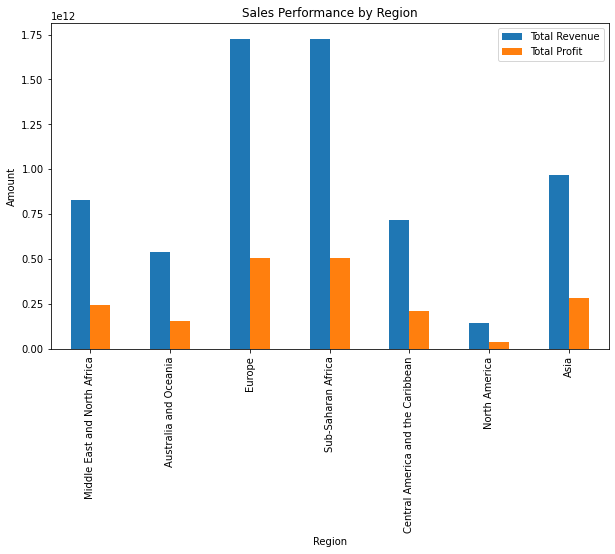

In [0]:
import matplotlib.pyplot as plt

# Assuming you have the following DataFrames: region_performance, item_performance, order_counts

# Plotting total revenue, total units sold, and total profit by region
region_performance_pd = region_performance.toPandas()
region_performance_pd.plot(x='Region', y=['Total Revenue',  'Total Profit'], kind='bar', figsize=(10, 6))
plt.xlabel('Region')
plt.ylabel('Amount')
plt.title('Sales Performance by Region')
plt.legend()
plt.show()



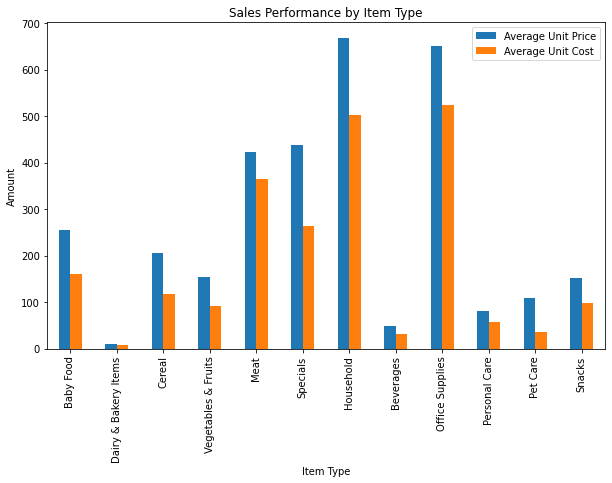

In [0]:
# Plotting average unit price and average unit cost by item type
item_performance_pd = item_performance.toPandas()
item_performance_pd.plot(x='Item Type', y=['Average Unit Price', 'Average Unit Cost'], kind='bar', figsize=(10, 6))
plt.xlabel('Item Type')
plt.ylabel('Amount')
plt.title('Sales Performance by Item Type')
plt.legend()
plt.show()

## Pricing Optimization:

Analyzing the relationship between price changes and sales volume to optimize pricing strategies and maximize revenue or profit margins.

In [0]:
from pyspark.sql.functions import avg, corr


# Calculate average unit price, average units sold, and average total profit by item type
item_price = df_sales.groupBy('Item Type').agg(avg('Total Profit').alias('Average Total Profit'))

# Calculate the correlation between unit price and units sold
price_vs_sold_corr = df_sales.select(corr('Unit Price', 'Units Sold')).first()[0]

# Calculate the correlation between unit price and total profit
price_vs_profit_corr = df_sales.select(corr('Unit Price', 'Total Profit')).first()[0]

# Print the results
item_price.show()
print(f"Correlation between Unit Price and Units Sold: {price_vs_sold_corr}")
print(f"Correlation between Unit Price and Total Profit: {price_vs_profit_corr}")


+--------------------+--------------------+
|           Item Type|Average Total Profit|
+--------------------+--------------------+
|           Baby Food|   479098.6055612629|
|Dairy & Bakery Items|  12046.468907509172|
|              Cereal|   442932.9605012658|
| Vegetables & Fruits|  315575.45959843625|
|                Meat|   286118.1124475283|
|            Specials|   869344.5837607597|
|           Household|   828713.8249790476|
|           Beverages|   78323.36074766611|
|     Office Supplies|   631416.2223113223|
|       Personal Care|  125277.36956689168|
|            Pet Care|  367226.77615493705|
|              Snacks|   275707.8761220979|
+--------------------+--------------------+

Correlation between Unit Price and Units Sold: 0.00017135183253730923
Correlation between Unit Price and Total Profit: 0.5772966631163301


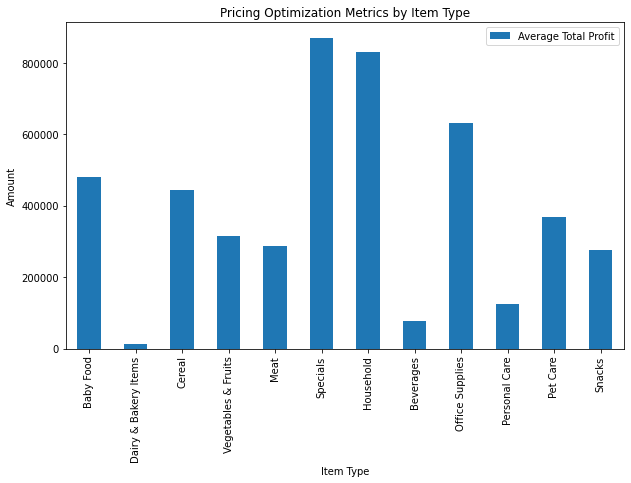

In [0]:
# Convert the Spark DataFrame to a Pandas DataFrame
item_price_pd = item_price.toPandas()

# Plotting the average unit price, average units sold, and average total profit by item type
item_price_pd.plot(x='Item Type', y=['Average Total Profit'], kind='bar', figsize=(10, 6))
plt.xlabel('Item Type')
plt.ylabel('Amount')
plt.title('Pricing Optimization Metrics by Item Type')
plt.legend()
plt.show()


## Sales Forecasting

Predicting future sales based on historical sales data, external factors, and seasonality to support inventory management, production planning, and revenue forecasting.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have a DataFrame called 'df_sales' with the specified columns

# Select the relevant columns for sales forecasting
sales_data = df_sales[['Order Date', 'Total Profit']].toPandas()

# Convert the 'Order Date' column to datetime format
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])

# Set 'Order Date' as the index of the DataFrame
sales_data.set_index('Order Date', inplace=True)

# Perform resampling to convert the data to monthly frequency
monthly_sales_data = sales_data.resample('M').sum()


# Splitthe data into train and test sets (80% train, 20% test)
train_size = int(len(monthly_sales_data) * 0.8)
train_data = monthly_sales_data[:train_size]
test_data = monthly_sales_data[train_size:]

# Fit the ARIMA model on the train data
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Forecast sales using the ARIMA model
forecast = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)



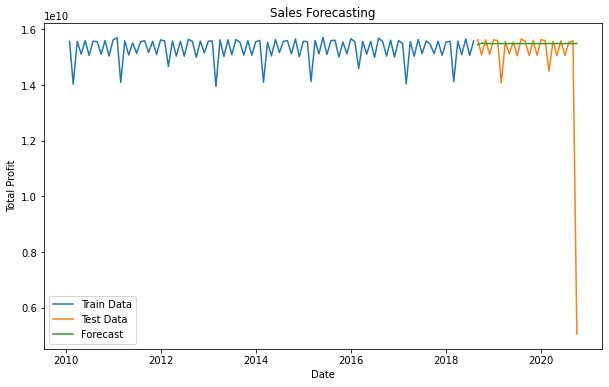

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales_data[:train_size],label='Train Data')
plt.plot(monthly_sales_data[train_size:],label='Test Data')
plt.plot(monthly_sales_data.index[train_size:], forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Profit')
plt.title('Sales Forecasting')
plt.legend()
plt.show()


## Sales Campaign Evaluation:

Assessing the effectiveness and ROI of marketing and sales campaigns by measuring the impact on sales, customer acquisition, and customer retention.

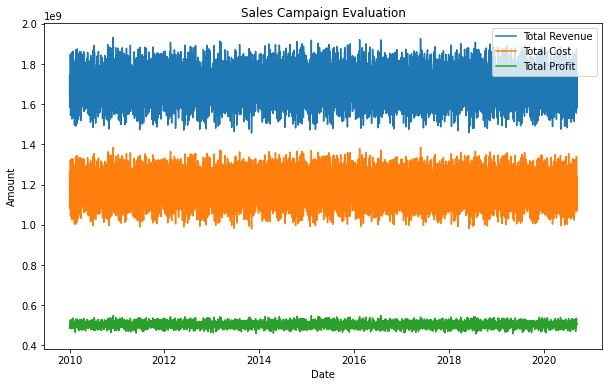

In [0]:
import pandas as pd
import matplotlib.pyplot as plt


# Select the relevant columns for sales campaign evaluation
campaign_data = df_sales[['Order Date', 'Total Revenue', 'Total Cost', 'Total Profit']].toPandas()

# Convert the 'Order Date' column to datetime format
campaign_data['Order Date'] = pd.to_datetime(campaign_data['Order Date'])

# Group the data by 'Order Date' and calculate the total revenue, total cost, and total profit
campaign_summary = campaign_data.groupby('Order Date').agg({'Total Revenue': 'sum', 'Total Cost': 'sum', 'Total Profit': 'sum'})

# Plot the total revenue, total cost, and total profit over time
plt.figure(figsize=(10, 6))
plt.plot(campaign_summary.index, campaign_summary['Total Revenue'], label='Total Revenue')
plt.plot(campaign_summary.index, campaign_summary['Total Cost'], label='Total Cost')
plt.plot(campaign_summary.index, campaign_summary['Total Profit'], label='Total Profit')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Sales Campaign Evaluation')
plt.legend()
plt.show()
